<a href="https://colab.research.google.com/github/Ayan1311819/MLP/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving names.txt to names.txt


In [ ]:
words = open('names.txt','r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [ ]:
#Building vocabulary and mapping of characters to/from integers
chars=sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0;
itos = {i:s for i,s in stoi.items()}
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
logits = torch.tensor([0.3,0.7,0.5,0.3]);
probs = torch.softmax(logits,dim=0);
loss = -probs[2].log()
logits, probs , loss
#l1 = 1.3863
#l2 = 1.2913


(tensor([0.3000, 0.7000, 0.5000, 0.3000]),
 tensor([0.2122, 0.3165, 0.2591, 0.2122]),
 tensor(1.3504))

In [ ]:
block_size = 3
X,Y = [], []
for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
print(X)
print(Y)
X.shape , X.dtype, Y.shape, Y.dtype

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [ ]:
#C = torch.randn((27,2))
#C[4]

In [ ]:
#F.one_hot(torch.tensor(X), num_classes=27).float() we will just index integers rather than using this

In [ ]:
C[X].shape #Indexing with multidimensional tensor of integers

torch.Size([32, 3, 2])

In [ ]:
emb = C[X] #embedding table
emb.shape


torch.Size([32, 3, 2])

In [ ]:
W1 = torch.randn(6,100)
b1 = torch.randn(100)
h = torch.tanh(emb.view(emb.shape[0],6) @ W1 + b1)
print(h.shape)


torch.Size([32, 100])


In [ ]:
#torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1).shape
#torch.cat(torch.unbind(emb,1),1).shape #cat creates a whole new T with new storage

In [ ]:
W2 =  torch.randn((100,27))
b2 = torch.randn(27)
logits = h @ W2 + b2
counts =  logits.exp()
prob = counts / counts.sum(1,keepdims=True)
prob.shape


torch.Size([32, 27])

In [ ]:
torch.argmax(prob[0])

tensor(16)

In [ ]:
prob[torch.arange(32),Y] #Tells the prob assigned by NN to the labels

tensor([1.6540e-16, 1.0637e-03, 8.8362e-12, 7.2039e-03, 2.8564e-10, 1.6302e-12,
        6.4722e-03, 2.1545e-05, 2.1691e-10, 1.2738e-15, 9.9930e-01, 9.4347e-08,
        1.8239e-07, 5.4099e-04, 1.1972e-12, 2.2520e-13, 3.7054e-11, 2.8619e-06,
        1.1879e-18, 1.2586e-06, 6.9566e-01, 1.4297e-05, 9.3024e-08, 5.9039e-09,
        8.5050e-12, 8.7622e-07, 3.0263e-17, 1.3906e-06, 2.8975e-10, 2.1801e-01,
        1.0000e+00, 1.0790e-04])

In [ ]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(17.2716)

In [ ]:
X.shape, Y.shape
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator=g)
W1 = torch.randn((6,100),generator=g)
b1 = torch.randn(100,generator=g)
W2 = torch.randn((100,27), generator=g)
b2 = torch.randn(27,generator=g)
parameters = [C,W1,W2,b1,b2]

In [ ]:
sum(p.nelement() for p in parameters) # no. of parameters in total

3481

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lre = torch.linspace(-3, 0, 1000) #stepping lineraly through the exponents
lrs = 10**lre
lrs .shape

torch.Size([1000])

In [ ]:
lri=[]
lossi=[]
for i in range(1000):
  #minibatch construct
  ix = torch.randint(0,X.shape[0],(32,))
  #forward pass
  emb = C[X[ix]] #(32,3,2)  embedding table
  h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100) hidden layer
  logits = h @ W2 + b2   # (32,27)
  #counts =  logits.exp()
  #prob = counts / counts.sum(1,keepdims=True)
  #loss = -prob[torch.arange(32),Y].log().mean()
  loss =  F.cross_entropy(logits,Y[ix])
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  #update
  lr = lrs[i]
  for p in parameters:
    p.data += -0.001 * p.grad
  # track stats
  #lri.append(lre[i])
  #lossi.append(loss.item())
print(loss.item())

2.471217632293701


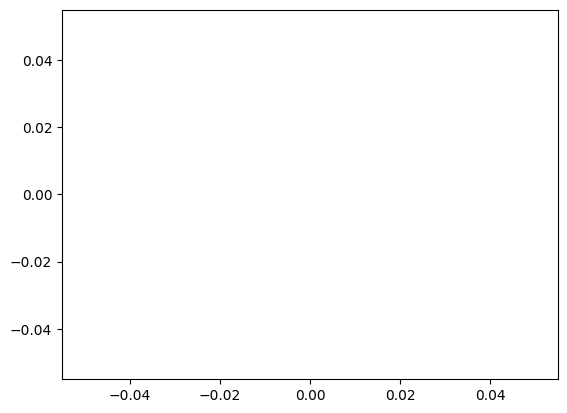

In [ ]:
#plt.plot(lri,lossi)

In [ ]:

emb = C[X] #(32,3,2)  embedding table
h = torch.tanh(emb.view(-1,6)@W1 + b1) #(32,100) hidden layer
logits = h @ W2 + b2   # (32,27)
loss =  F.cross_entropy(logits,Y)
loss

tensor(2.3424, grad_fn=<NllLossBackward0>)

In [ ]:
#Training split, dev/validation split, test split
# 80% , 10%(hyperparameters) , 10%
Sum